# Comparamos el modelo predictivo original con modelos de menos variables.

En este notebook vamos a comparar la performance del modelo XGB orientado a precisión que seleccionamos para la app1 respecto a modelos similares, optimizados con la misma metodología pero con menor cantidad de variables de entrada. El objetivo es poder utilizar un modelo reducido para generar una experiencia de usuario más satisfactoria y eficiente en la app2. La app2 determina la probabilidad de baja del cliente a partir de un formulario de carga manual y a partir de allí generar instrucciones para el agente.

## Importación módulos y dataset

In [1]:
#Instalación de adjusText para que no se superpongan los textos de los modelos en el scatterplot.
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7096 sha256=92e1c1f5700eff5035984393e59b2a4e8efd117056193ab564c7fde4dc9b978d
  Stored in directory: /root/.cache/pip/wheels/06/b2/e0/b239bd2c0ff89b98c4f0c86a63e7059f38a8dfaf6df2641c63
Successfully built adjustText


In [2]:
#Importación librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from adjustText import adjust_text
import time
from google.colab import drive

In [3]:
#Importación dataset desde github 
#Obtenido de Kaggle https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
url='https://raw.githubusercontent.com/neoncoip/practice/main/Telco_customer_churn.csv'
telco = pd.read_csv(url, sep=';')

In [4]:
#Definimos función para calcular las métricas relevantes para cada modelo que construyamos
def met_gra(y_test, y_pred_test, y_train, y_pred_train, want_return=True):
  """Calcula el recall, la precisión sobre los datos de prueba e imprime resultados. 
     Calcula f1 sobre datos de prueba y entrenamiento y muestra el cociente (para monitorear el fitting).
     Muestra la matriz de confusión y grafica recall vs precision"

  Args:
    y_test (pandas.Series): etiquetas de datos de prueba.
    y_pred_test (pandas.Series): predicción sobre datos de prueba.
    y_train (pandas.Series): etiquetas de datos de entrenamiento.
    y_pred_train (pandas.Series): predicción sobre datos de entrenamiento.
    want_return (bool, optional): permite no devolver nada.

  Returns:
    float: recall redondeado a 2 decimales.
    float: precision redondeado a 2 decimales.
    float: cociente entre f1 sobre datos de prueba y f1 sobre datos de entrenamiento redondeado a 2 decimales.
  """ 
  
  #Seteamos decimales para el redondeo
  deci = 2
  
  #Calculamos F1 para train y test para monitorear el overfiting
  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred_test)
  
  #Calculamos las métricas relevantes del problema e imprimimos resultados
  rec_score = recall_score(y_test, y_pred_test)
  pre_score = precision_score(y_test, y_pred_test)
  print('test/train F1= '+round(test_f1/train_f1, deci).astype(str),
        'recall = '+round(rec_score, deci).astype(str),
        'precision = '+round(pre_score, deci).astype(str), sep='\n')
  
  #Graficamos matriz de confusión y matrix PR
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='all', labels=[1, 0], colorbar=False, cmap='BuPu', ax=ax[0])
  PrecisionRecallDisplay.from_predictions(y_test, y_pred_test, ax=ax[1])
  plt.legend(loc='best')
  plt.show()
  
  #Devolvemos los valores en caso que se especifique lo contrario en el llamado
  if want_return:
    return round(rec_score, 2), round(pre_score, 2), round(test_f1, 3)

In [5]:
#Creamos función para entrenar y testear modelos
def modelar(X, y):
  """Divide los datos en set de entrenamiento y prueba.
     Ejecuta un un RandomSearchCV sobre un clasificador XGB.
     Almacena modelos y métricas relevantes de performance a través de la función "met_gra"
  
  Args:
     X (pandas.DataFrame): Dataset sin las etiquetas
     y (pandas.Series): Etiquetas

  Return:
    (pandas.Dataframe): nombre, recall, precision, mejor estimador y predicciones

  Notes:
    También guarda en el directorio local los modelos entrenados en formato txt
  """

  #Dividimos los datos en set de entrenamiento y de prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

  #Definimos métricas que vamos a testear en el RSCV
  metrics = ['precision', 'recall', 'average_precision'] #'balanced_accuracy' y 'f1' convergen con recall

  #Definimos métricas de evaluación interna de XGB (Habíamos incluído 'auc' y 'logloss' también pero terminaban convergiendo a valores similares de precision y recall)
  eval_metrics = ['aucpr']

  #Definimos hyperparámetros para testear
  eta = [0.03, 0.1, 0.3]
  max_depth = [2, 3, 6, 10]
  subsample = [0.5, 0.8, 1]
  spw = [1, 3]

  #Definimos porcentaje de pruebas en relación a las combinaciones posibles
  random_ratio = 0.2

  #Definimos cantidad de iteraciones del RSCV
  n_iter = len(eta) * len(max_depth) * len(subsample) * len(spw) * random_ratio 

  #Creamos y preparamos dataframe para guardar y comparar métricas de cada modelo testeado
  models = pd.DataFrame()
  models['metrics'] = []
  models['recall'] = []
  models['precision'] = []
  models['bestimator'] = []
  models['test_predictions'] = []

  #Para monitorear el tiempo de ejecución definimos tiempo de comienzo
  start = time.time()
 
  #Iteramos a través de las métricas de evalución del modelo (estamos usando una sola en este momento: 'aucpr') y de las de scoring del Random Search
  for em in eval_metrics:
    for m in metrics:
      xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=seed)
      param_distributions = {'eta': eta,  
                            'max_depth': max_depth,                              
                            'subsample': subsample,
                            'scale_pos_weight': spw,                        
                            'eval_metric': [em]}
      
      #Instanciamos un Random Search CV con nuestro estimador, el diccionario de parámetros y la métrica de scoring corriente
      xgb_rscv = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_distributions, scoring=m, cv=5, n_jobs=-1, random_state=seed, n_iter=n_iter)
      
      #Entrenamos el modelo
      xgb_rscv.fit(X_train, y_train)
      
      #Obtenemos las mejores predicciones sobre el set de prueba y testeo
      y_pred_test = xgb_rscv.best_estimator_.predict(X_test)
      y_pred_train = xgb_rscv.best_estimator_.predict(X_train)
      
      #Mostramos los datos relevantes del mejor modelo para cada métrica de scoring
      print('Evaluation:', em, ' - Scoring metric:', m)
      print(xgb_rscv.best_params_)
      rs, ps, _= met_gra(y_test, y_pred_test, y_train, y_pred_train)
      
      #Guardamos los datos de cada iteración en un mismo dataframe
      models = models.append({'metrics': em+'-'+m, 'recall': rs, 'precision': ps, 'bestimator': xgb_rscv.best_estimator_, 'test_predictions': y_pred_test}, ignore_index=True)
      print('\n')

      #Guardamos cada modelo en un archivo (para usar en la implementación 1)
      xgb_rscv.best_estimator_.save_model(f'{em}-{m}-{X.shape[1]}var.txt')  

      #Plotemos la lista de atributos y su importancia relativa
      fig, ax = plt.subplots(figsize=(10, np.sqrt(X.shape[1]-2)))
      xgb.plot_importance(xgb_rscv.best_estimator_, ax=ax, height=0.5, color='gold')
      plt.grid(False)
      plt.show()

  #Calculamos y mostramos el tiempo de ejecución
  end = time.time()
  elapsed = end - start
  print(f'Elapsed: {round(elapsed/60)} minutes\n')

  #Devolvemos modelos y sus métricas
  return models

## XGBoost classifier hyperparameter tuning - Variables modelo original

Evaluation: aucpr  - Scoring metric: precision
{'subsample': 1, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.99
recall = 0.58
precision = 0.68


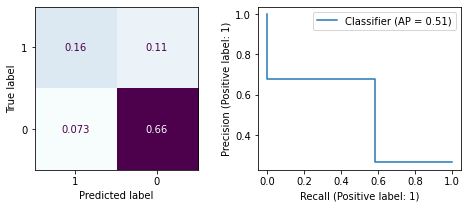

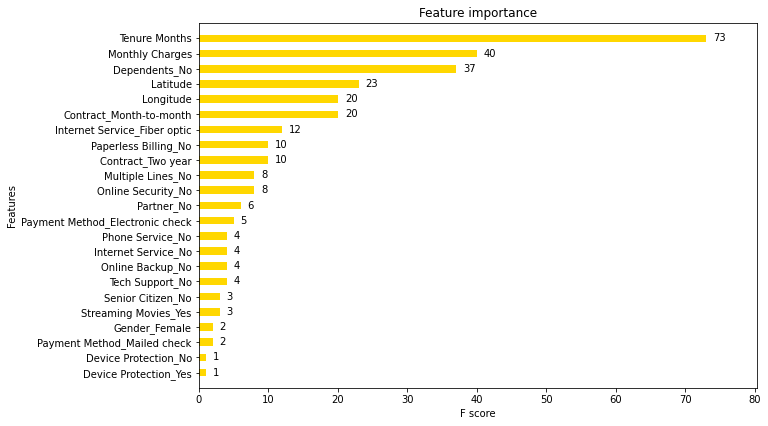

Evaluation: aucpr  - Scoring metric: recall
{'subsample': 0.8, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.98
recall = 0.83
precision = 0.52


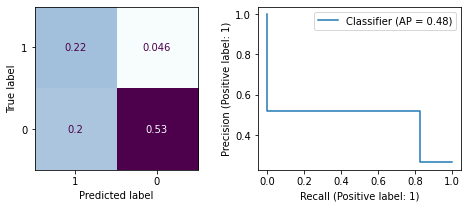

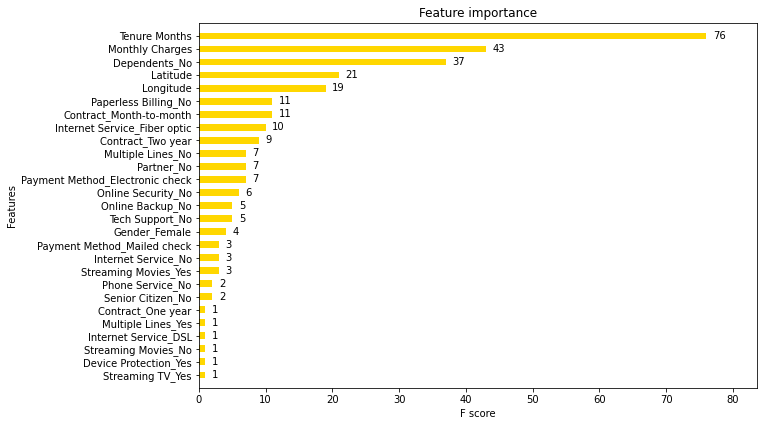

Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.99
recall = 0.59
precision = 0.68


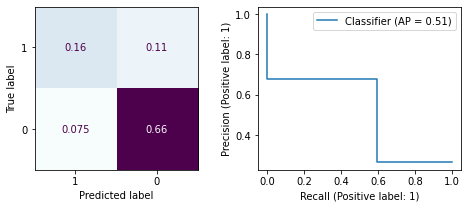

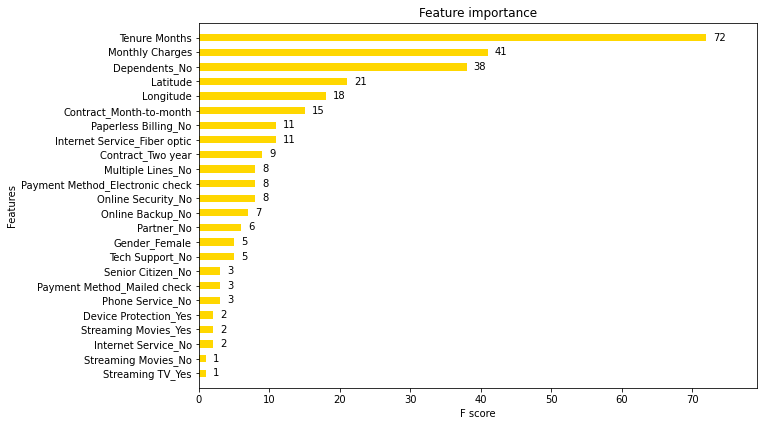

Elapsed: 4 minutes



In [6]:
#Definimos semilla
seed=1972

#Asignamos serie de etiquetas
y = telco['Churn Value'].copy()

#Asignamos a un nuevo dataframe el dataset original sin las columnas comentadas
X_pre = telco.drop(['CustomerID', 'Count', 'Country', 'City', 'Zip Code', 'State', 'Lat Long', 'Churn Label', 'Churn Value', 'Churn Score', 'Churn Reason', 'CLTV', 'Total Charges'], axis=1)

#Definimos una lista con las columnas a convertir a número (Esto lo hallamos en el Análisis )
cols = ['Longitude', 'Latitude', 'Monthly Charges']

#Reemplazamos la coma por punto y el espacio por nada y convertimos a número
X_pre[cols] = X_pre[cols].apply(lambda x: x.str.replace(',', '.')).apply(lambda x: x.str.replace(' ', '0')).apply(lambda x: pd.to_numeric(x))

#Convertimos variables categóricas a nuevas variables binarias.
X = pd.get_dummies(X_pre)

#Generamos modelo y métricas
models_ori = modelar(X, y)

## XGBoost classifier hyperparameter tuning - 8 variables 

Evaluation: aucpr  - Scoring metric: precision
{'subsample': 1, 'scale_pos_weight': 1, 'max_depth': 3, 'eval_metric': 'aucpr', 'eta': 0.3}
test/train F1= 0.94
recall = 0.55
precision = 0.66


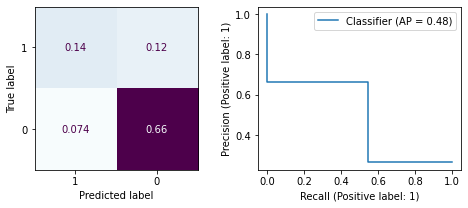

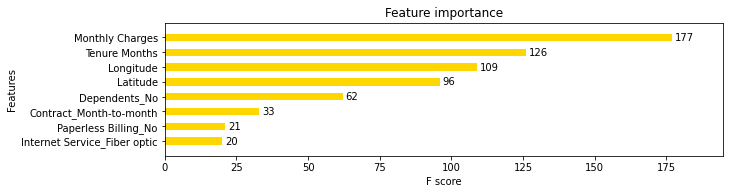

Evaluation: aucpr  - Scoring metric: recall
{'subsample': 0.8, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.96
recall = 0.81
precision = 0.51


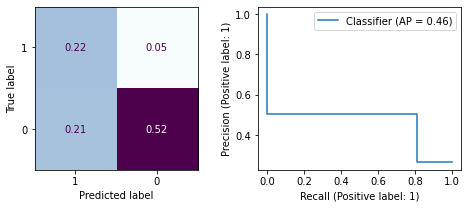

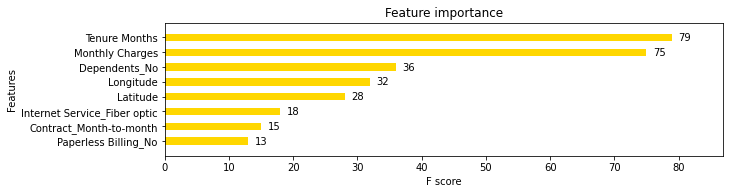

Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.99
recall = 0.58
precision = 0.66


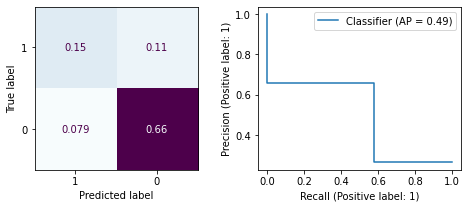

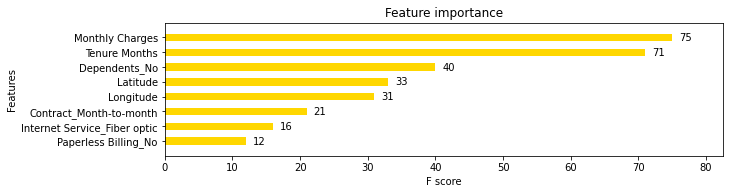

Elapsed: 1 minutes



In [7]:
#Nos quedamos con las primeras 8 variables obtenidas en 'Ranking atributos modelos principales'
X_8var = X[['Tenure Months', 'Monthly Charges', 'Dependents_No', 'Latitude', 'Longitude', 'Paperless Billing_No', 'Contract_Month-to-month', 'Internet Service_Fiber optic']]

#Generamos modelo y métricas
models_8var = modelar(X_8var, y)

## XGBoost classifier hyperparameter tuning - 5 variables 

Evaluation: aucpr  - Scoring metric: precision
{'subsample': 1, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 1.03
recall = 0.48
precision = 0.69


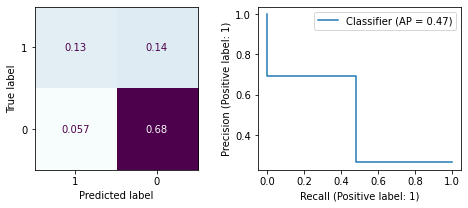

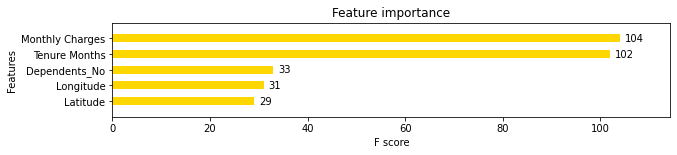

Evaluation: aucpr  - Scoring metric: recall
{'subsample': 1, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.97
recall = 0.82
precision = 0.49


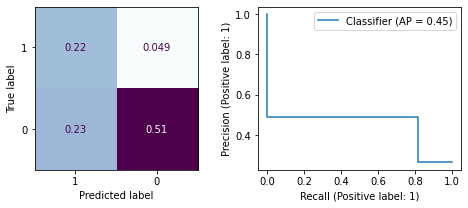

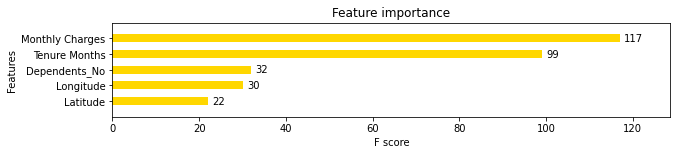

Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 1, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.97
recall = 0.82
precision = 0.49


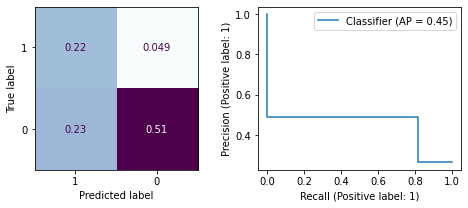

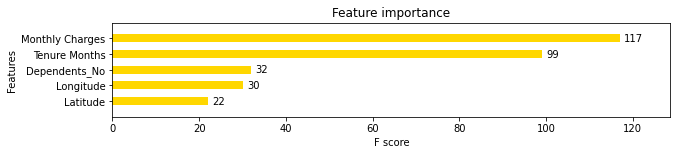

Elapsed: 1 minutes



In [8]:
#Nos quedamos con las primeras 8 variables obtenidas en 'Ranking atributos modelos principales'
X_5var = X[['Tenure Months', 'Monthly Charges', 'Dependents_No', 'Latitude', 'Longitude']]

#Generamos modelo y métricas
models_5var = modelar(X_5var, y)

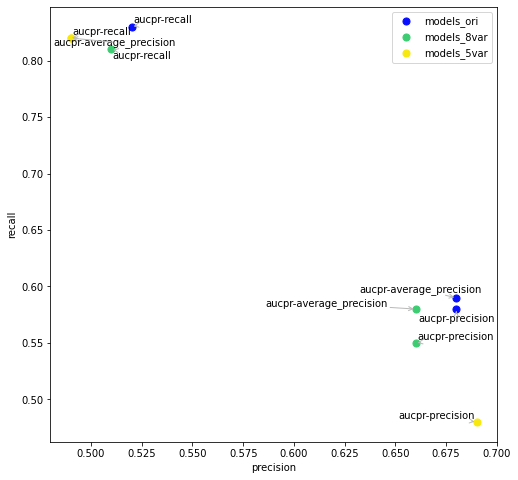

In [9]:
#Mostramos los resultados de precision y recall
fig, ax = plt.subplots()
texts = []
for models, color, label in zip([models_ori, models_8var, models_5var],['#080ffc','#3dcc72','#f7e811'], ['models_ori', 'models_8var', 'models_5var']):
  models.plot(ax=ax, kind='scatter', x='precision', y='recall', figsize=(8,8), c=color, s=50, label=label)
  for i in range(models.shape[0]):
    texts.append(plt.text(models['precision'][i], models['recall'][i], models['metrics'][i]))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#bababa'), force_text=(0.3,0.6))
ax.legend()
plt.show()

# Conclusiones preliminares 1 - Cantidad de variables del modelo

>Los modelos de 8 variables, 'aucpr-average_precision' y 'aucpr-precision' logran una precisión del 66%, frente a un 68% que logra el modelo original, en cuanto a recall la diferencia es de 55% y 58% respectivamente frente al 59% del modelo original. <br>
>El modelo de 5 variables logra una precisión de 69% apenas mayor que el modelo original pero con un recall sustancialmente más bajo en 48%. Además es en el único caso, de todos los ensayados hasta el momento, que al optimizar el Randon Search CV con una métrica de scoring relacionada con precisión converge a una zona donde tendríamos los modelos orientados a recall. Esto podría representar una inestabilidad del modelo y ofrecernos resultados muy distintos si tuvieramos que volver a entrenar el modelo 'aucpr-precision' con nuevos valores. <br>
>Por lo tanto profundizaremos el compartmiento de los modelos de 8 variables ('aucpr-average_precision' y 'aucpr-precision') en los rangos superiores de precisión.

In [15]:
#Definimos función para generar pares de recall-precision en función al threshold, calcular medias y error relativo
def rec_pre_pairs(trained_model, X, y, seed):
  """Genera pares de recall-precision para diferentes threshold en diferentes columnas

  Args:
    trained_model (str): nombre del archivo/modelo entrenado 
    X (pandas.DataFrame): datos sin etiquetas
    y (pandas.Series): etiquetas
    seed (int): semilla para el random_state del train_test_split

  Return:
    (pandas.DataFrame): recall, precision y threshold
  """  
  #Seteamos parámetros para definir intervalos de estudio y creamos una lista para almacenar los valores de threshold
  desde=0.5
  hasta=0.95
  definición=9 #Cuántos intervalos
  thresh = []
  
  #Instanciamos nuevo modelo y cargamos modelo entrenado
  model_replica = xgb.XGBClassifier()
  model_replica.load_model(trained_model)

  #Dividimos los datos en set de entrenamiento y de prueba
  _, X_test, _, y_test = train_test_split(X, y, random_state=seed, stratify=y)
  
  #Generamos valores de probabilidad para churn positivo y los concatenamos a las predicciones reales.
  proba =  model_replica.predict_proba(X_test)[:,1]
  data_plus_proba = pd.concat([y_test.reset_index()['Churn Value'], pd.DataFrame(proba, columns = ['Proba'])], axis=1)
  
  #Generamos las etiquetas binarias (columnas), para poder calcular recalll y precision
  for i in range(definición+1):
    data_plus_proba[f'gt{i*10}'] = data_plus_proba['Proba'].apply(lambda x: 1 if x>=desde+i*(hasta-desde)/definición else 0)
    thresh.append(round(desde+i*(hasta-desde)/definición, 2)) 

  #Calculamos y almacenamos valores de recall y precision
  rec_pre = pd.DataFrame()
  rec_pre['recall'] = []
  rec_pre['precision'] = []
  for col in data_plus_proba:
    if col not in ['Churn Value', 'Proba']:
      recall = round(recall_score(data_plus_proba['Churn Value'], data_plus_proba[col], zero_division=0), 2)
      precision = round(precision_score(data_plus_proba['Churn Value'], data_plus_proba[col], zero_division=0), 2) 
      rec_pre = rec_pre.append({'recall': recall, 'precision': precision}, ignore_index=True)
  rec_pre['thresh'] = thresh
  
  return rec_pre

In [16]:
#Definimos función para calcular medias y error relativo de los resultados que entrega rec_pre_pairs
def rec_pre_avg_and_error(modelo, X, y):
  """Llama a la función rec_pre_pairs, calcula media, desviaci´´on estándar y error relativo para precision y recall para cada threshold

  Args:
    modelo (str): nombre del archivo/modelo entrenado 
    X (pandas.DataFrame): datos sin etiquetas
    y (pandas.Series): etiquetas

  Return:
    (pandas.DataFrame): recall y precisión promedio, desviación estándar del recall y precisión, error relativo del recall y precisión, threshold
  """

  #Definimos dataframes donde vamos a almacenar y promediar valores
  recall_df = pd.DataFrame()
  precision_df = pd.DataFrame()
  recall_df_std = pd.DataFrame()
  precision_df_std = pd.DataFrame()
  avg_and_error = pd.DataFrame()

  #Generamos n iteraciones de la función con diferente semilla y guardamos series de recall y precision
  repeticiones = 30
  for i in range(repeticiones):
    pairs = rec_pre_pairs(modelo, X, y, i)
    recall_df.insert(i, i, pairs['recall'])
    precision_df.insert(i, i, pairs['precision'])

  #Calculamos la media de ambas métricas
  avg_and_error['re_avg'] = recall_df.mean(axis=1).round(2)
  avg_and_error['pre_avg'] = precision_df.mean(axis=1).round(2)

  #Calculamos las desviaciones estándar para ambos grupos de datos y lo sumamos al dataframe donde ya teníamos los promedios
  import statistics as st

  re_std = []
  for row in recall_df.iterrows():
    re_std.append(st.stdev(row[1]))
  avg_and_error['re_std'] = pd.Series(re_std)

  pre_std = []
  for row in precision_df.iterrows():
    pre_std.append(st.stdev(row[1]))
  avg_and_error['pre_std'] = pd.Series(pre_std)

  #Calculamos el error relativo con sigma=1.96 para asegurarnos un 95% de precisión en la estimación del error.
  sigma = 1.96
  avg_and_error['re_rel_error'] = sigma * avg_and_error['re_std']/avg_and_error['re_avg']
  avg_and_error['pre_rel_error'] = sigma * avg_and_error['pre_std']/avg_and_error['pre_avg']
  avg_and_error['thresh'] = pairs['thresh']
  avg_and_error.replace(0, np.nan, inplace=True)
  
  return avg_and_error

In [17]:
import glob
models = glob.glob("*8var.txt")

models_data = []
for model in models:
  response = rec_pre_avg_and_error(model, X_8var, y)
  models_data.append(response)
  model_name = f'{model}'[:-4]
  response.to_csv(f'{model_name}.csv')
  print(model_name, response, sep='\n')

aucpr-precision-8var
   re_avg  pre_avg    re_std   pre_std  re_rel_error  pre_rel_error  thresh
0    0.58     0.69  0.017840  0.012149      0.060288       0.034509    0.50
1    0.49     0.72  0.019678  0.015916      0.078714       0.043328    0.55
2    0.41     0.75  0.018495  0.016709      0.088416       0.043667    0.60
3    0.30     0.81  0.017499  0.025042      0.114325       0.060597    0.65
4    0.23     0.88  0.016761  0.029449      0.142830       0.065591    0.70
5    0.14     0.90  0.015421  0.036141      0.215898       0.078708    0.75
6    0.08     0.95  0.011885  0.034032      0.291194       0.070213    0.80
7    0.03     0.96  0.006477  0.044851      0.423177       0.091571    0.85
8     NaN     0.67  0.001826  0.479463           inf       1.402609    0.90
9     NaN      NaN       NaN       NaN           NaN            NaN    0.95
aucpr-recall-8var
   re_avg  pre_avg    re_std   pre_std  re_rel_error  pre_rel_error  thresh
0    0.85     0.52  0.014700  0.010807      0.033

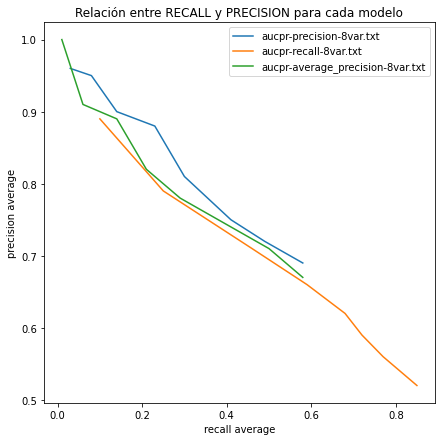

In [18]:
fig, ax = plt.subplots(figsize=(7,7))
for data, name in zip(models_data, models):
  data.plot(ax=ax, label=name, kind='line', y='pre_avg', x='re_avg')
ax.set_xlabel('recall average')
ax.set_ylabel('precision average')
ax.set_title('Relación entre RECALL y PRECISION para cada modelo')
plt.show()

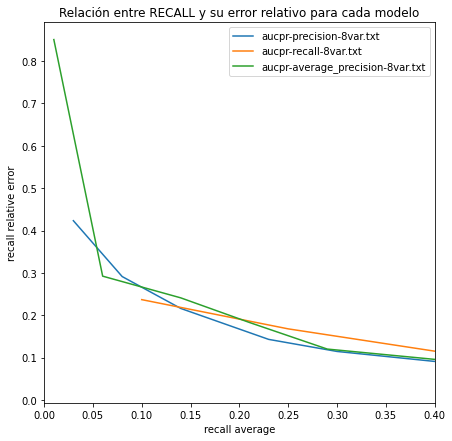

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
for data, name in zip(models_data, models):
  data.plot(ax=ax, label=name, kind='line', x='re_avg', y='re_rel_error')
  plt.xlim(0, 0.4)
ax.set_xlabel('recall average')
ax.set_ylabel('recall relative error')
ax.set_title('Relación entre RECALL y su error relativo para cada modelo')
plt.show()

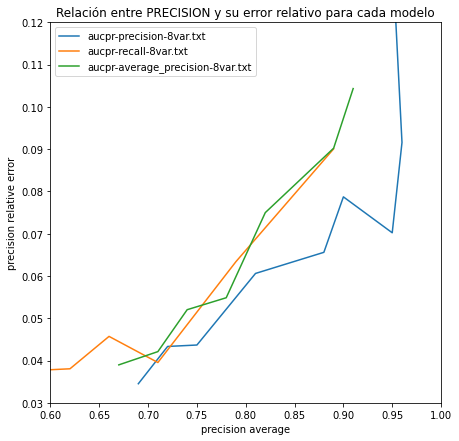

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
for data, name in zip(models_data, models):
  data.plot(ax=ax, label=name, kind='line', x='pre_avg', y='pre_rel_error')
  plt.xlim(0.6, 1)
  plt.ylim(0.03, 0.12)
ax.set_xlabel('precision average')
ax.set_ylabel('precision relative error')
ax.set_title('Relación entre PRECISION y su error relativo para cada modelo')
plt.show()  

# Conclusiones finales - Elección de modelo

>El modelo de 8 variables 'aucpr-precision' resulta la mejor opción para trabajar con el rango superior de preción dado que:<br>
* A igual valor de precisión otorga mejores valores de recall, aproximadamente un 50% más para el rango de 80%~90% de precisión.
* Tiene los menores valores de error relativo para la precision. Entre 1% y 2% menor en el rango de 75% y 90%, lo que representa aproximadamente un error relativo 20% menor.